# Transfer Learning for Compound Treats Disease Relationship

Based on previous experiments, the next step is to answer the question: Can label functions transfer between realtionship types? This notebook is designed to answer this question by testing the hypothesis: **Compound Binds Gene (CbG) label functions transfer better than Disease Associates Gene (DaG) functions when classifiying Compound Treats Disease sentences.** To test this hypothesis, we plan to train multiple generative models and measure each models performance in the form of Receiver Operative Cruves (ROC) and Precision-Recall Curves (PRCs) 

## Set up the Environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))
sys.path.append(os.path.abspath('data/label_functions/'))

import pandas as pd
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import LabelAnnotator
from snorkel.models import candidate_subclass

from metal.label_model import LabelModel

from compound_disease_lf import CD_LFS
from disease_gene_lf import DG_LFS
from compound_gene_lf import CG_LFS
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.label_matrix_helper import (
    get_columns, label_candidates, get_auc_significant_stats
)
from utils.notebook_utils.plot_helper import plot_label_matrix_heatmap, plot_curve, plot_generative_model_weights

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])

In [5]:
quick_load = False

## Load the Label Matrix

Before we begin training the generative model, we need to load label matricies for each training/testing set. This process involves extracting annotations from the postgress database shared on this local machine. 

In [6]:
spreadsheet_names = {
    'train': 'data/sentences/sentence_labels_train.xlsx',
    'dev': 'data/sentences/sentence_labels_train_dev.xlsx',
    'test': 'data/sentences/sentence_labels_dev.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 50000
Size of dev set: 50
Size of test set: 50


In [8]:
label_functions = (
    list(CD_LFS['CtD_DB'].values()) + 
    list(CD_LFS['CtD_TEXT'].values()) + 
    list(CD_LFS['CD_BICLUSTER'].values()) + 
    list(CG_LFS["CbG_TEXT"].values())+
    list(DG_LFS["DaG_TEXT"].values())
) 

if quick_load:
    label_matricies = pickle.load(open("data/label_matricies.pkl", "rb"))

else:
    label_matricies = {
        key:label_candidates(
            session,
            candidate_dfs[key]['candidate_id'],
            label_functions,
            num_threads=10,
            batch_size=candidate_dfs[key]['candidate_id'].shape[0]
        )
        for key in candidate_dfs
    }
    
    pickle.dump(label_matricies, open("data/label_matricies.pkl", "wb"))

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

  49990
      0

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

     40
      0

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

     40
      0

In [14]:
lf_names =(
    list(CD_LFS['CtD_DB'].keys()) + 
    list(CD_LFS['CtD_TEXT'].keys()) + 
    list(CD_LFS['CD_BICLUSTER'].keys()) + 
    list(CG_LFS["CbG_TEXT"].keys())+
    list(DG_LFS["DaG_TEXT"].keys())
)

## Observe Label Function Properties

Before training the generative model, it is a good idea to observe label functions and their output. In the cells below we take a look at generated heatmaps and observe the underlying structure.

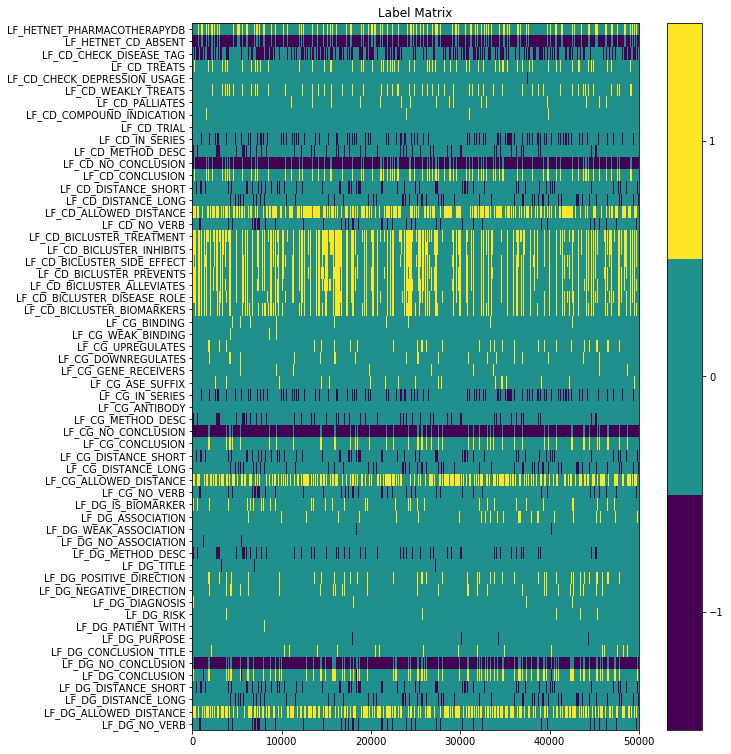

In [16]:
plot_label_matrix_heatmap(label_matricies['train'].T, 
                          yaxis_tick_labels=lf_names, 
                          figsize=(10,13))

# Train Generative Model

In [24]:
cd_db = list(range(len(CD_LFS['CtD_DB'].keys())))
cd_text = list(range(cd_db[-1]+1, cd_db[-1]+len(CD_LFS['CtD_TEXT'].keys())))
cd_bicluster = list(range(cd_text[-1]+1, cd_text[-1]+len(CD_LFS['CD_BICLUSTER'].keys())))
cg_text = list(range(cd_bicluster[-1]+1, cd_bicluster[-1]+len(CG_LFS['CbG_TEXT'].keys())))
dg_text = list(range(cg_text[-1]+1, cg_text[-1]+len(DG_LFS['DaG_TEXT'].keys())))

In [27]:
# Dictionary specifying the different models 
# for this analysis
model_dict = {
    "CtD_DB": cd_db,
    "CtD_TEXT": cd_text,
    "CD_BICLUSTER": cd_bicluster,
    "CbG_TEXT": cg_text,
    "DaG_TEXT": dg_text,
    "CtD_DB_TEXT": cd_db+cd_text,
    "CtD_ALL": cd_db+cd_text+cd_bicluster,
    "All_the_jawns": cd_db+cd_text+cd_bicluster+cg_text+dg_text
}   

In [28]:
L = label_matricies['train'].toarray()
L[L < 0] = 2
L_dev = label_matricies['dev'].toarray()
L_dev[L_dev < 0] = 2
L_test = label_matricies['test'].toarray()
L_test[L_test < 0] = 2

label_model = LabelModel(k=2, seed=100)

In [30]:
reg_param_grid = pd.np.round(pd.np.linspace(1e-1, 1, num=30), 3)
grid_results = defaultdict(dict)
for model in tqdm_notebook(model_dict):
    for reg_param in reg_param_grid:
        label_model.train_model(L[:, model_dict[model]], n_epochs=1000, verbose=False, lr=0.01, l2=reg_param)
        grid_results[model][str(reg_param)] = label_model.predict_proba(L_dev[:, model_dict[model]])[:,0]

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

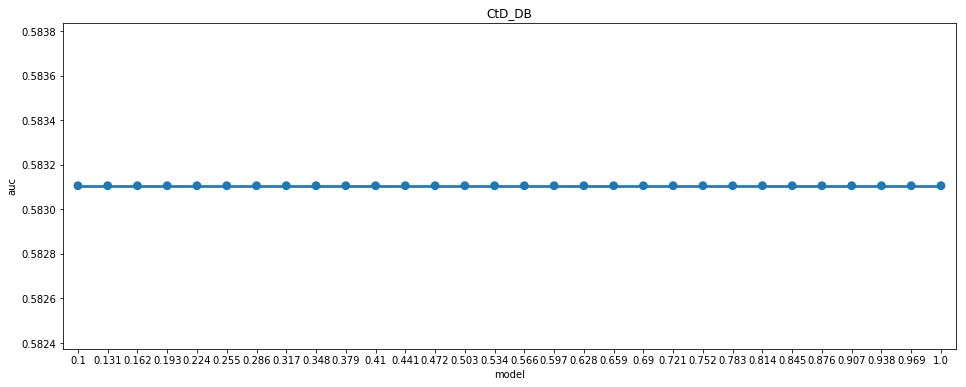

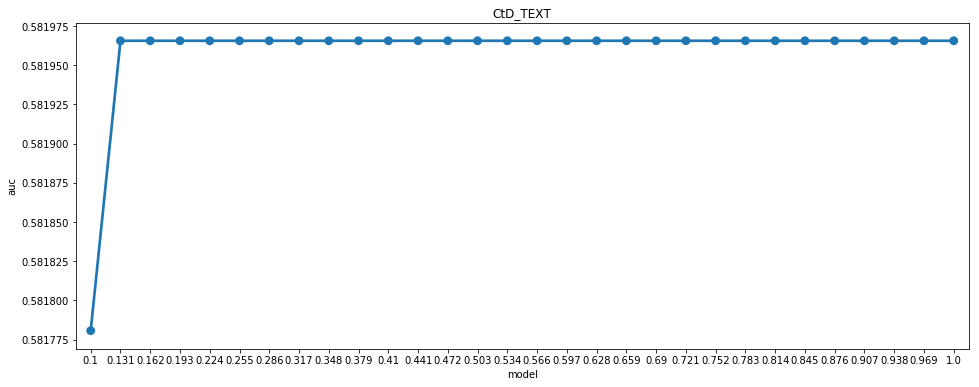

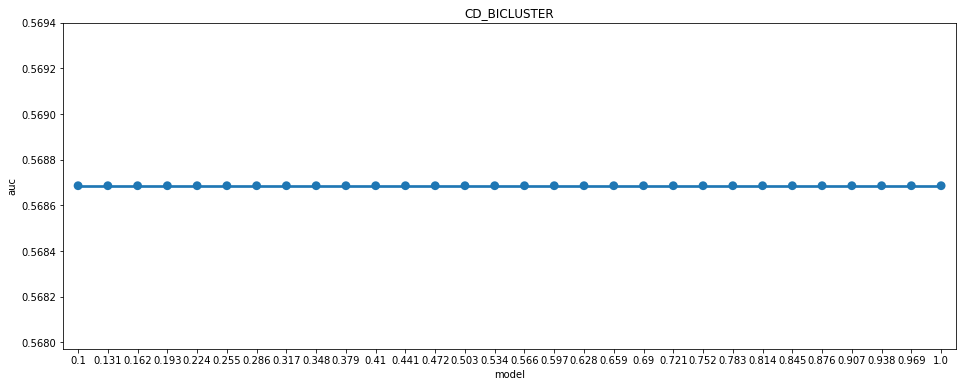

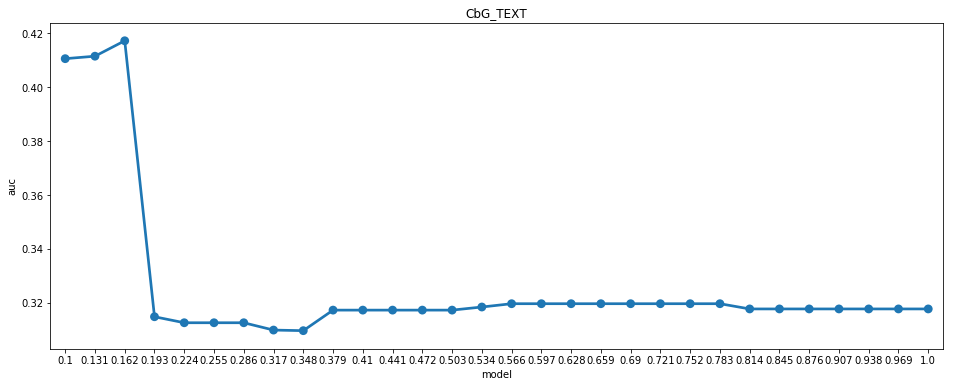

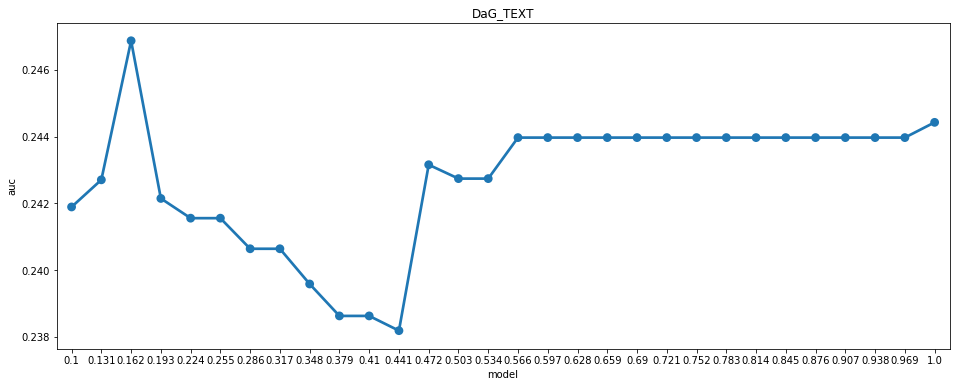

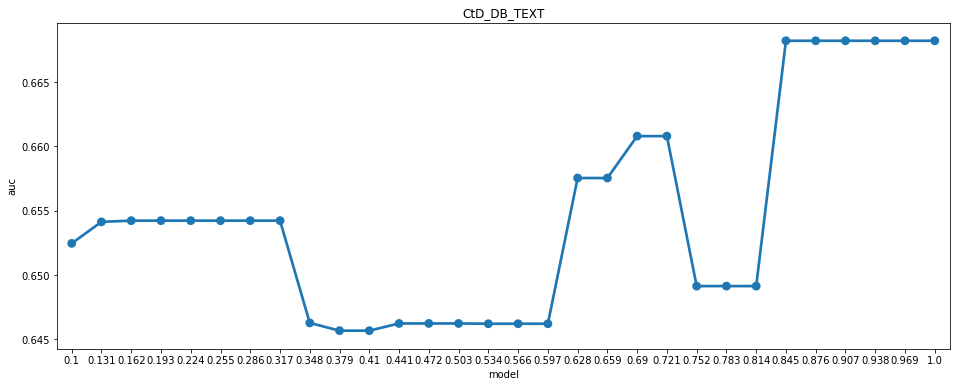

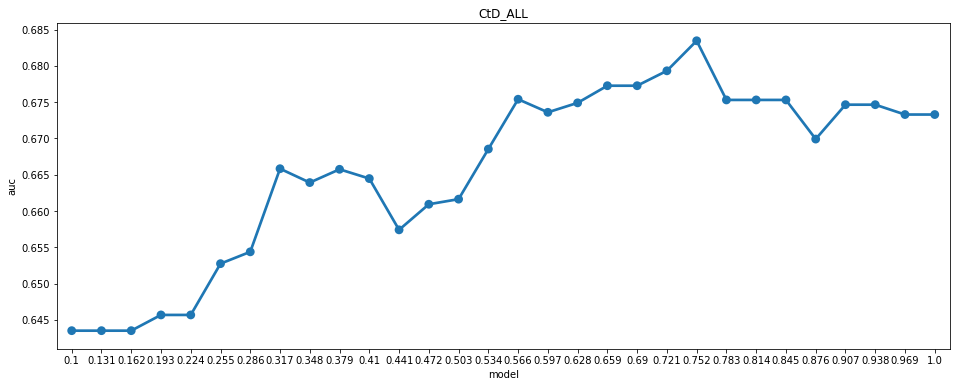

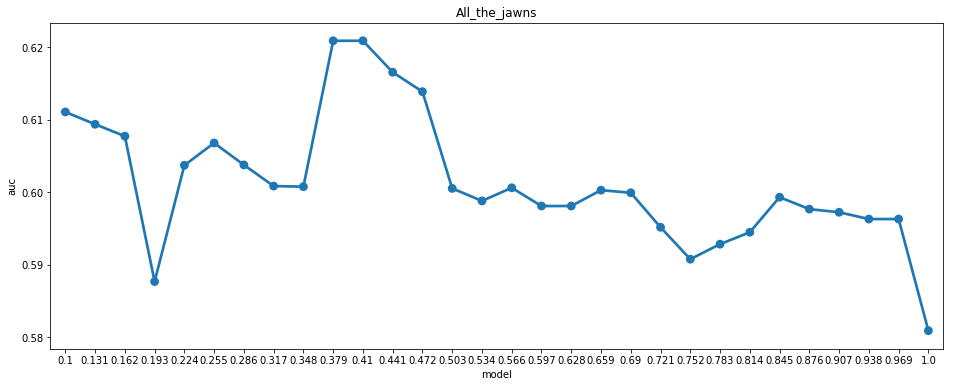

In [36]:
for model in grid_results:
    model_aucs = plot_curve(
        pd.DataFrame.from_dict(grid_results[model]),
        candidate_dfs['dev'].curated_dsh, 
        figsize=(16,6), model_type='scatterplot', 
        plot_title=model, metric='PR', font_size=10
    )

In [38]:
best_params = {
    "CtD_DB":0.1,
    "CtD_TEXT": 0.162,
    "CD_BICLUSTER": 0.1,
    "CbG_TEXT": 0.162,
    "DaG_TEXT":0.566,
    "CtD_DB_TEXT": 0.876,
    "CtD_ALL": 0.752,
    "All_the_jawns": 0.41
}
final_dev_model = {}
final_test_model = {}
for model in tqdm_notebook(best_params):
    label_model.train_model(L[:, model_dict[model]], n_epochs=1000, verbose=False, lr=0.01, l2=best_params[model])
    final_dev_model[model] = label_model.predict_proba(L_dev[:, model_dict[model]])[:,0]
    final_test_model[model] = label_model.predict_proba(L_test[:, model_dict[model]])[:,0]

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [39]:
dev_marginals_df = pd.DataFrame.from_dict(final_dev_model)
dev_marginals_df.head(2)

,CtD_DB,CtD_TEXT,CD_BICLUSTER,CbG_TEXT,DaG_TEXT,CtD_DB_TEXT,CtD_ALL,All_the_jawns
0,0.154174,0.999474,0.500000,0.967224,0.362756,0.949162,0.987682,0.938358
1,0.154174,0.328586,0.986778,0.933886,0.362756,0.078695,0.513152,0.828288


In [40]:
test_marginals_df = pd.DataFrame.from_dict(final_test_model)
test_marginals_df.head(2)

,CtD_DB,CtD_TEXT,CD_BICLUSTER,CbG_TEXT,DaG_TEXT,CtD_DB_TEXT,CtD_ALL,All_the_jawns
0,0.982789,0.328586,1.0,0.933886,0.362756,0.681245,0.999896,0.999985
1,0.154174,0.126469,1.0,0.997515,0.216094,0.002637,0.989832,0.999966


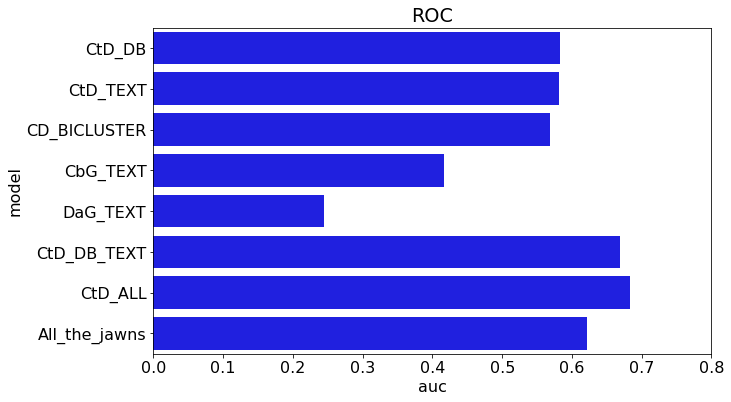

In [44]:
model_aucs = plot_curve(dev_marginals_df, candidate_dfs['dev'].curated_dsh, model_type='barplot',metric='PR',
                           xlim=[0,0.8])

In [45]:
get_auc_significant_stats(candidate_dfs['dev'], model_aucs)

mu: 272.000000, sigma: 48.083261


,auroc,u,z_u,p_value
CtD_DB,0.583106,317.209670,0.940237,0.173548
CtD_TEXT,0.581966,316.589295,0.927335,0.176876
CD_BICLUSTER,0.568686,309.365319,0.777096,0.218551
CbG_TEXT,0.417211,226.962750,-0.936651,0.825531
DaG_TEXT,0.243969,132.719218,-2.896658,0.998114
CtD_DB_TEXT,0.668217,363.510019,1.903158,0.028510
CtD_ALL,0.683463,371.803639,2.075642,0.018964
All_the_jawns,0.620898,337.768568,1.367806,0.085686


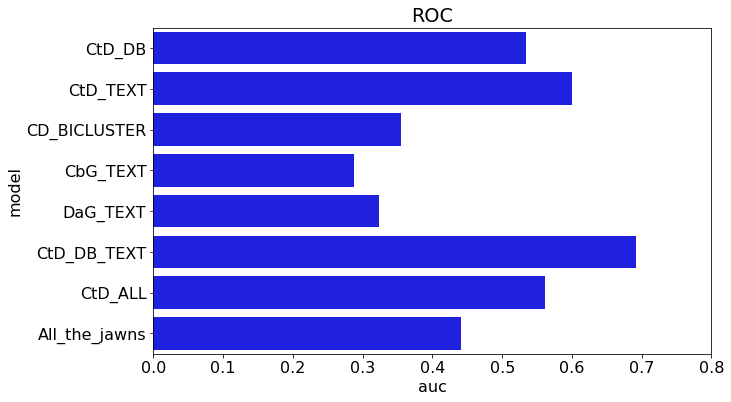

In [48]:
model_aucs = plot_curve(test_marginals_df, candidate_dfs['test'].curated_dsh, model_type='barplot',metric='PR',
                           xlim=[0,0.8])

In [49]:
get_auc_significant_stats(candidate_dfs['test'], model_aucs)

mu: 272.000000, sigma: 48.083261


,auroc,u,z_u,p_value
CtD_DB,0.533990,290.490769,0.384557,0.350283
CtD_TEXT,0.600374,326.603719,1.135608,0.128060
CD_BICLUSTER,0.354383,192.784519,-1.647465,0.950269
CbG_TEXT,0.288174,156.766423,-2.396542,0.991725
DaG_TEXT,0.322757,175.579867,-2.005274,0.977533
CtD_DB_TEXT,0.692028,376.463079,2.172546,0.014907
CtD_ALL,0.561491,305.450839,0.695686,0.243313
All_the_jawns,0.440460,239.610353,-0.673616,0.749722
